In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rigidbody.plotter as plotter
import rigidbody.ode_solver as ode

In [2]:
plotter.set_context("paper")

In [3]:
def differential_drive_dynamic(x:np.ndarray, u:np.ndarray, r:float=1., a:float=0.5)-> np.ndarray:
    """
    Unicycle dynamics.
    The state x contains (x,y,phi).
    The input u contains (theta_r_dot, theta_l_dot)

    Parameters
    ----------
    u: np.ndarray (2,)
    x: np.ndarray (3,)
    r: radius of the wheel
    a: width of the car

    Returns
    -------
    dx_dt: np.ndarray (3,)
    """

    return np.array([[0.5*r*np.cos(x[-1]),0.5*r*np.cos(x[-1])],
                     [0.5*r*np.sin(x[-1]),0.5*r*np.sin(x[-1])],
                     [r/(2*a),-r/(2*a)]])@u

In [140]:
N_t = 3000
dt = 5e-4
magnitude = 5
t_raw = np.arange(N_t)*dt
t_span = 1.5*(1 - np.exp(-1*t_raw))
desired_x = magnitude*np.cos(2 * np.pi * t_span) - 1
desired_y = magnitude*np.sin(2 * np.pi * t_span)
desired_xy = np.block([[desired_x], [desired_y]]).T

In [141]:
controlled_trajectory = np.zeros((t_span.shape[0],3))
controlled_trajectory[0] = np.array([desired_xy[0,0],desired_xy[0,1],np.pi/3])+1e-0*np.random.randn(3)

In [173]:
K_p_v = 5e1
K_i_v = 4e-3
K_p_phi = 1e2
K_i_phi = 1e-2

max_speed_control = 60

sum_norm_e = 0
sum_e_phi = 0
u_hist = []
for i in range(t_span.shape[0]-1):
    e = desired_xy[i,:2] - controlled_trajectory[i,:2]
    norm_e = np.linalg.norm(e)
    theta_plus_dot = K_p_v*norm_e + K_i_v*sum_norm_e
    theta_plus_dot = np.minimum(theta_plus_dot,max_speed_control)
    sum_norm_e += norm_e
    phi_d = np.arctan2(e[1],e[0])

    #since phi_d can only be [0,2pi] this need to be handled properly
    if phi_d-controlled_trajectory[i,-1] < -np.pi:
        phi_d=phi_d+2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    elif phi_d-controlled_trajectory[i,-1] > np.pi:
        phi_d=phi_d-2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    else:
        phi_d = phi_d

    e_phi = (phi_d-controlled_trajectory[i,-1])
    sum_e_phi += e_phi
    theta_min_dot = K_p_phi*e_phi + K_i_phi*sum_e_phi
    theta_r_dot_ = 0.5*(theta_plus_dot+theta_min_dot)
    theta_l_dot_ = 0.5*(theta_plus_dot-theta_min_dot)
    u_ = np.array([theta_r_dot_,theta_l_dot_])
    u_hist.append(u_)
    controlled_trajectory[i+1] = ode.rk_one_step(differential_drive_dynamic,controlled_trajectory[i],dt,u_)
u_hist = np.stack(u_hist)

Text(0, 0.5, '$y$')

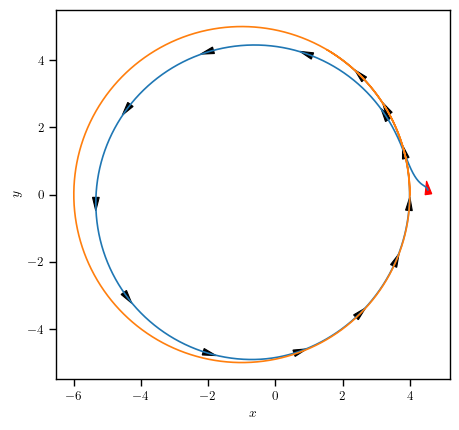

In [174]:
ax = plotter.two_d_trajectory_attitude_plot(controlled_trajectory,0.10,200,initial_color="red")
ax.plot(desired_xy[:,0],desired_xy[:,1])
ax.set_aspect("equal")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

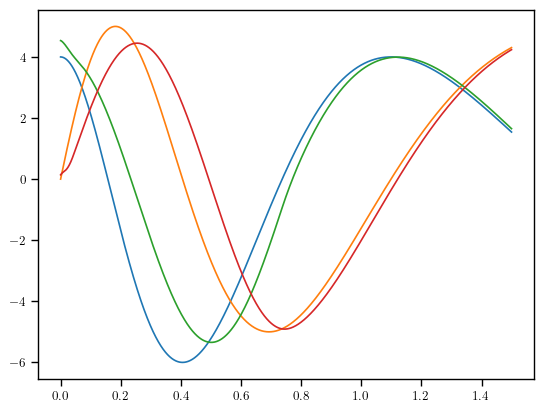

In [175]:
plt.plot(t_raw,desired_xy)
plt.plot(t_raw,controlled_trajectory[:,:2])

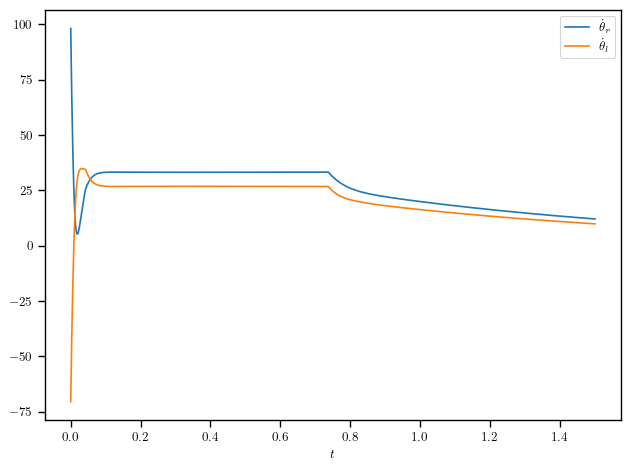

In [176]:
plt.plot(t_raw[1:],u_hist, label=[r"$\dot\theta_r$",r"$\dot\theta_l$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()

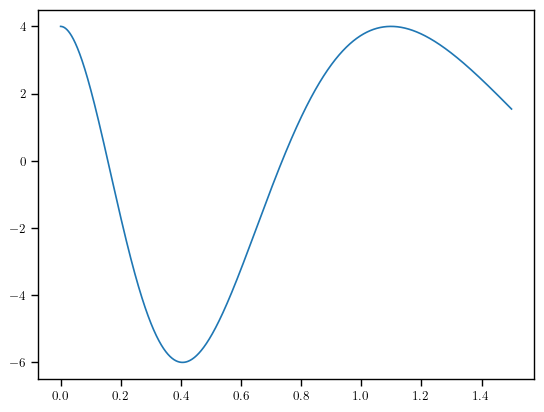

In [172]:
plt.plot(t_raw,desired_xy[:,0])